In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from synchronous_gossip_protocol import generate_nodes_and_run_stf, NodeGenerator, StateTransitionFunction

sns.set_theme()

# Number of adversarial nodes 

In [2]:
def s_adv(p, k):
    return (1 - p) * p**k

Text(0, 0.5, '$Pr(s_{adv} = k)$')

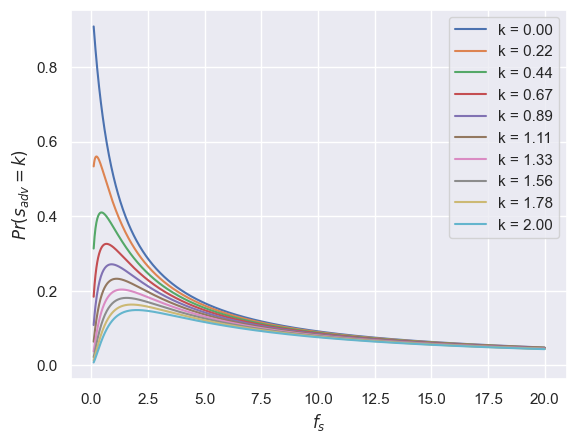

In [3]:
fig, ax = plt.subplots()

fs = np.linspace(0.1, 20, 1000)
ps = fs / (fs + 1)
ks = np.linspace(0, 2, 10)

for k in ks:
    s_sdvs = [s_adv(p, k) for p in ps]
    sns.lineplot(x=fs, y=s_sdvs, ax=ax, label=f"k = {k:.2f}")

ax.set_xlabel(r"$f_s$")
ax.set_ylabel(r"$Pr(s_{adv} = k)$")

## Set up parameters

In [4]:
total_nodes = 10000
frac_sample = 0.1
frac_honest_sample = 0.7
frac_adversarial_sample = 0.3

assert frac_adversarial_sample + frac_honest_sample == 1

num_honest_sample_nodes = int(frac_honest_sample * frac_sample * total_nodes)
num_adversarial_sample_nodes = int(frac_adversarial_sample * frac_sample * total_nodes)
num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
time_steps = 100
num_connected_nodes = 7

assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes

## Generate and initialize nodes

In [5]:
node_generator = NodeGenerator(
    num_non_sample_nodes=num_non_sample_nodes,
    num_honest_sample_nodes=num_honest_sample_nodes,
    num_adversarial_sample_nodes=num_adversarial_sample_nodes
)

sample_nodes, non_sample_nodes = node_generator.initialize_nodes()

# Each node contains a list of its peers
node_generator.link_nodes(
    generator=node_generator.randomly_connected_nodes(
        total_nodes=sample_nodes + non_sample_nodes,
        num_connected_nodes=num_connected_nodes
    )
)

## Time evolve states

In [6]:
state_transition_func = StateTransitionFunction(
    sample_nodes=sample_nodes,
    non_sample_nodes=non_sample_nodes
)

states = state_transition_func.iterate_state(time_steps)

In [7]:
# Convert state result to a pandas DataFrame for analysis
df = pd.DataFrame(states).T
df = df[df.columns].astype(float)

## State variation of all nodes with time

Track the variation of sample and non-sample nodes as a function of time (in cycles of the STF)

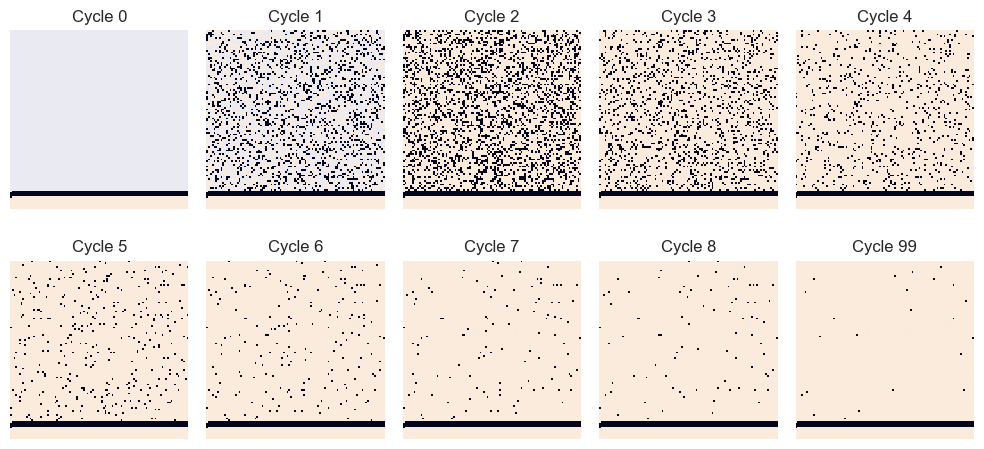

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

plot_idx = 0
for idx in [*range(9), 99]:
    axis = ax[plot_idx // 5, plot_idx % 5]
    data = df[idx].to_numpy().reshape((int(np.sqrt(df.shape[0])), int(np.sqrt(df.shape[0]))))
    sns.heatmap(data, ax=axis, square=True, cbar=False, xticklabels=False, yticklabels=False)
    axis.set_title(f"Cycle {idx}")
    plot_idx += 1

fig.tight_layout()

## State variation and convergence of non-sample nodes with time

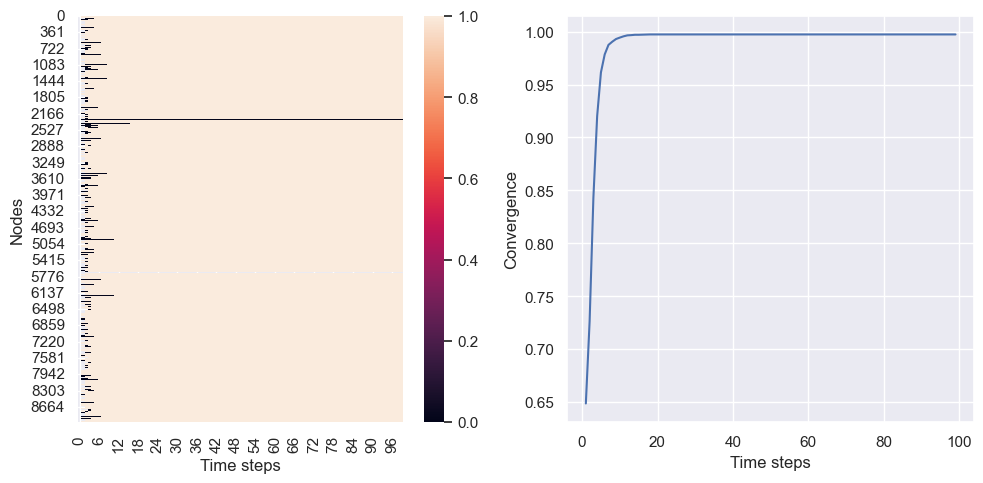

In [9]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(df[:num_non_sample_nodes - 1], ax=ax)
ax.set_xlabel("Time steps")
ax.set_ylabel("Nodes")

sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax1)
ax1.set_xlabel("Time steps")
ax1.set_ylabel("Convergence")
fig.tight_layout()

# Variation with s

Here we look at the convergence behavior with varying fraction of sample nodes.

To improve speed we reduce the total number of nodes to 1000. The fraction of adversarial sample nodes is pinned to 0.3 * number of sample nodes. Again, we are looking at the worst case scenario with all adversarial nodes emmitting the same value.

Text(0.5, 1.0, 'Variation with fraction of sample nodes $f_s = s/n$, ($s_{adv}/s = 0.3$)')

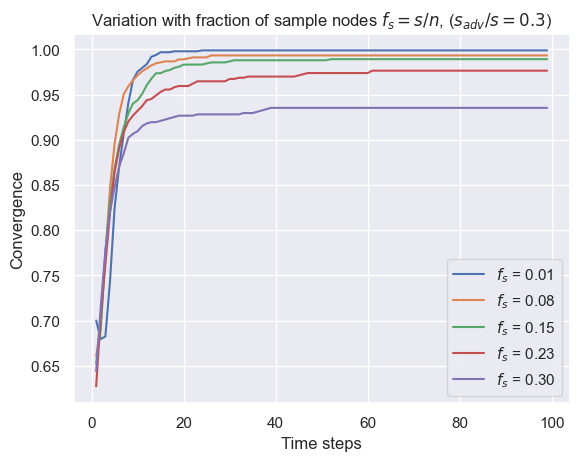

In [10]:
total_nodes = 1000

fig, ax = plt.subplots()

sample_fractions = np.linspace(0.01, 0.3, 5)

for sample_fraction in sample_fractions:
    frac_adversarial_sample = 0.3
    frac_honest_sample = 1 - frac_adversarial_sample

    assert frac_honest_sample + frac_adversarial_sample == 1
    
    num_honest_sample_nodes = int(total_nodes * sample_fraction * frac_honest_sample)
    num_adversarial_sample_nodes = int(total_nodes * frac_adversarial_sample * sample_fraction)
    num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
    time_steps = 100
    num_connected_nodes = 5

    assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes
    
    states = generate_nodes_and_run_stf(
        num_non_sample_nodes=num_non_sample_nodes,
        num_honest_sample_nodes=num_honest_sample_nodes,
        num_adversarial_sample_nodes=num_adversarial_sample_nodes,
        num_connected_nodes=num_connected_nodes,
        time_steps=time_steps
    )

    df = pd.DataFrame(states).T
    df = df[df.columns].astype(float)

    sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax, label=rf"$f_s$ = {sample_fraction:.2f}")
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Convergence")
ax.set_title(r"Variation with fraction of sample nodes $f_s = s/n$, ($s_{adv}/s = 0.3$)")

# Variation with f

Here we look at the convergence behavior with varying fraction of adversarial nodes.

The fraction of sample nodes is pinned to 0.01

Text(0.5, 1.0, 'Variation with fraction of adversarial sample $f_{adv} = s_{adv} / s$, ($s/n = 0.01$)')

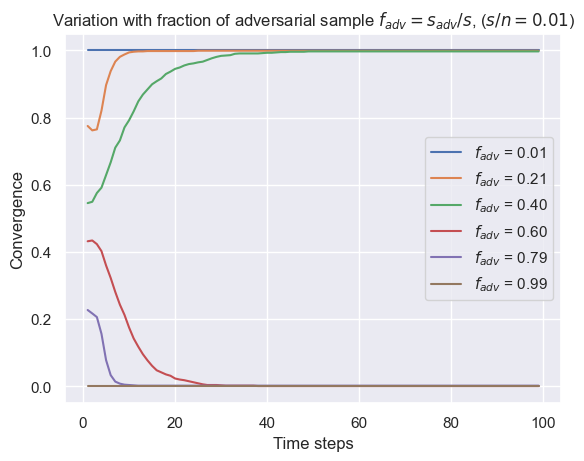

In [11]:
total_nodes = 1000

fig, ax = plt.subplots()

adversarial_sample_fractions = np.linspace(0.01, 0.99, 6)
sample_fraction = 0.01

for frac_adversarial_sample in adversarial_sample_fractions:
    frac_honest_sample = 1 - frac_adversarial_sample

    assert frac_honest_sample + frac_adversarial_sample == 1
    
    num_honest_sample_nodes = int(total_nodes * sample_fraction * frac_honest_sample)
    num_adversarial_sample_nodes = int(total_nodes * frac_adversarial_sample * sample_fraction)
    num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
    time_steps = 100
    num_connected_nodes = 5

    assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes
    
    states = generate_nodes_and_run_stf(
        num_non_sample_nodes=num_non_sample_nodes,
        num_honest_sample_nodes=num_honest_sample_nodes,
        num_adversarial_sample_nodes=num_adversarial_sample_nodes,
        num_connected_nodes=num_connected_nodes,
        time_steps=time_steps
    )

    df = pd.DataFrame(states).T
    df = df[df.columns].astype(float)

    sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax, label=r"$f_{adv}$ = " + f"{frac_adversarial_sample:.2f}")
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Convergence")
ax.set_title(r"Variation with fraction of adversarial sample $f_{adv} = s_{adv} / s$, ($s/n = 0.01$)")

# Variation with K

Here we look at the convergence behavior with varying fraction of connected nodes.

The fraction of sample nodes is pinned to 0.01, and adversarial nodes is pinned to 0.15

Text(0.5, 1.0, 'Variation with fraction of connected nodes $f_{K} = K / n$, ($s/n = 0.01, f_{adv} = 0.3$)')

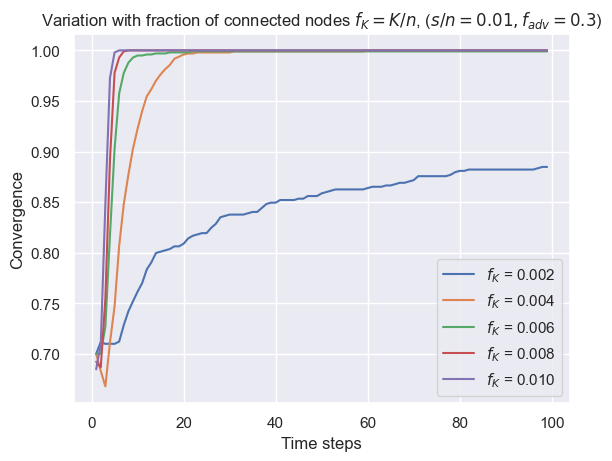

In [12]:
total_nodes = 1000

fig, ax = plt.subplots()

num_connected_fractions = np.linspace(0.002, 0.01, 5)
sample_fraction = 0.01

for num_connected_frac in num_connected_fractions:
    frac_adversarial_sample = 0.3
    frac_honest_sample = 1 - frac_adversarial_sample

    assert frac_honest_sample + frac_adversarial_sample == 1
    
    num_honest_sample_nodes = int(total_nodes * sample_fraction * frac_honest_sample)
    num_adversarial_sample_nodes = int(total_nodes * frac_adversarial_sample * sample_fraction)
    num_non_sample_nodes = total_nodes - (num_honest_sample_nodes + num_adversarial_sample_nodes)
    time_steps = 100
    num_connected_nodes = int(num_connected_frac * total_nodes)
    
    assert num_non_sample_nodes + num_honest_sample_nodes + num_adversarial_sample_nodes == total_nodes
    
    states = generate_nodes_and_run_stf(
        num_non_sample_nodes=num_non_sample_nodes,
        num_honest_sample_nodes=num_honest_sample_nodes,
        num_adversarial_sample_nodes=num_adversarial_sample_nodes,
        num_connected_nodes=num_connected_nodes,
        time_steps=time_steps
    )

    df = pd.DataFrame(states).T
    df = df[df.columns].astype(float)

    sns.lineplot(df[:num_non_sample_nodes - 1].mean(axis=0), ax=ax, label=r"$f_K$ = " + f"{num_connected_frac:.3f}")
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Convergence")
ax.set_title(r"Variation with fraction of connected nodes $f_{K} = K / n$, ($s/n = 0.01, f_{adv} = 0.3$)")

# Distribution of storage size on non-sample nodes

Limiting the storage $C$ limits the node's ability to maintain "receipts" of all messages, but since we use a max(counter) algorithm, it does not affect the final result.

<Axes: >

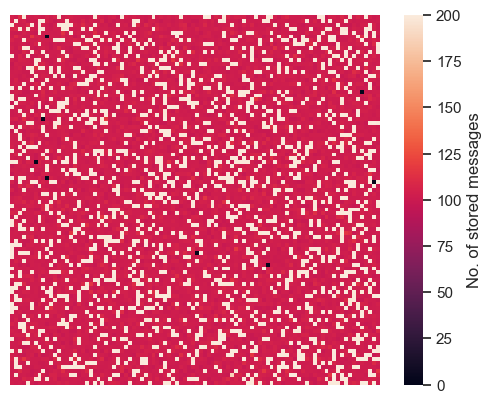

In [52]:
fig, ax = plt.subplots()

num_messages = np.zeros(len(state_transition_func.non_sample_nodes))

for idx, node in enumerate(state_transition_func.non_sample_nodes):
    num_messages[idx] = len(node.stored_messages)

# Since no. of non sample nodes, may not be a perfect square, round down to generate square heatmap
pixels = int(np.sqrt(len(num_messages)))
sns.heatmap(num_messages[:pixels**2].reshape((pixels, pixels)), cbar_kws={"label": "No. of stored messages"}, 
            xticklabels=False, yticklabels=False, square=True)